#### Forecast Demand whit ARIMA Model

In [29]:
# Importing Basic libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import re
# Importing time series specific libraries
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import bartlett
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima.model import ARIMA
import pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.statespace import sarimax
import prophet
from prophet import Prophet
from scipy.stats import levene
# Miscellaneous libararies
import warnings
warnings.filterwarnings('ignore')
from math import sqrt
from random import random

# Libaraies for evaluation of model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from statsmodels.tsa.arima.model import ARIMAResults


In [30]:
 #?  Function for solver data import
def import_data(x):
    """Import the data from a file into the Excel document"""
    global df 
    route_script = os.getcwd()
# Excel name :
    name_doc = x
#Combine script route and name_doc
    route_doc=os.path.join(route_script,name_doc)
#Load data in a Data Frame to panda 
    df=pd.read_excel(route_doc)
    return df

In [31]:
 #?Call the function for data analysis 
import_data("load_IJV.xlsx")

,idprov,fecha,dem1,dem2,dem3,dem4,dem5,dem6,dem7,dem8,...,dem16,dem17,dem18,dem19,dem20,dem21,dem22,dem23,dem24,dem25
0,IJV,2007-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IJV,2007-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IJV,2007-07-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IJV,2007-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IJV,2007-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3915,IJV,2018-04-14,15.0,14.0,13.0,13.0,13.0,13.0,13.0,12.0,...,12.0,12.0,13.0,14.0,15.0,16.0,16.0,16.0,15.0,16.0
3916,IJV,2018-04-15,15.0,14.0,14.0,13.0,13.0,13.0,12.0,12.0,...,12.0,12.0,13.0,14.0,15.0,15.0,16.0,16.0,15.0,16.0
3917,IJV,2018-04-16,14.0,13.0,13.0,13.0,12.0,13.0,12.0,12.0,...,12.0,12.0,12.0,12.0,14.0,14.0,14.0,13.0,12.0,14.0
3918,IJV,2018-04-17,11.0,11.0,10.0,10.0,10.0,10.0,10.0,10.0,...,11.0,11.0,12.0,13.0,14.0,14.0,14.0,13.0,12.0,14.0


In [32]:
 #? shaping the data, only the last 10 years (2008 - 2017)
df = df[df["fecha"] >= '2008-01-01']
df = df[df["fecha"] <= '2017-12-31']
print(df.head())

    idprov      fecha  dem1  dem2  dem3  dem4  dem5  dem6  dem7  dem8  ...  \
159    IJV 2008-01-01   9.0   9.0   8.0   8.0   8.0   9.0   9.0  10.0  ...   
160    IJV 2008-01-02   8.0   6.0   8.0   7.0   8.0   8.0   8.0  10.0  ...   
161    IJV 2008-01-03   6.0   4.0   5.0   6.0   6.0   5.0  10.0  10.0  ...   
162    IJV 2008-01-04   6.0   6.0   7.0   6.0   6.0   8.0  10.0  11.0  ...   
163    IJV 2008-01-05   6.0   6.0   6.0   6.0   6.0   8.0   9.0  10.0  ...   

     dem16  dem17  dem18  dem19  dem20  dem21  dem22  dem23  dem24  dem25  
159   11.0   12.0   14.0   15.0   12.0   11.0   11.0   10.0   10.0   16.0  
160   12.0   15.0   17.0   16.0   11.0    9.0    8.0    7.0    6.0   17.0  
161   11.0   15.0   18.0   17.0   12.0   10.0    9.0    7.0    7.0   19.0  
162   12.0   14.0   18.0   19.0   13.0   10.0    9.0    7.0    7.0   19.0  
163   12.0   11.0   18.0   19.0   14.0   11.0   10.0    8.0    8.0   20.0  

[5 rows x 27 columns]


In [33]:
 #? removing last column
infoToUse = df.drop(columns="dem25")
print(infoToUse.head())

    idprov      fecha  dem1  dem2  dem3  dem4  dem5  dem6  dem7  dem8  ...  \
159    IJV 2008-01-01   9.0   9.0   8.0   8.0   8.0   9.0   9.0  10.0  ...   
160    IJV 2008-01-02   8.0   6.0   8.0   7.0   8.0   8.0   8.0  10.0  ...   
161    IJV 2008-01-03   6.0   4.0   5.0   6.0   6.0   5.0  10.0  10.0  ...   
162    IJV 2008-01-04   6.0   6.0   7.0   6.0   6.0   8.0  10.0  11.0  ...   
163    IJV 2008-01-05   6.0   6.0   6.0   6.0   6.0   8.0   9.0  10.0  ...   

     dem15  dem16  dem17  dem18  dem19  dem20  dem21  dem22  dem23  dem24  
159   11.0   11.0   12.0   14.0   15.0   12.0   11.0   11.0   10.0   10.0  
160    8.0   12.0   15.0   17.0   16.0   11.0    9.0    8.0    7.0    6.0  
161   11.0   11.0   15.0   18.0   17.0   12.0   10.0    9.0    7.0    7.0  
162   11.0   12.0   14.0   18.0   19.0   13.0   10.0    9.0    7.0    7.0  
163   11.0   12.0   11.0   18.0   19.0   14.0   11.0   10.0    8.0    8.0  

[5 rows x 26 columns]


In [34]:
 #? restarting the index
infoToUse.index = np.arange(1, len(infoToUse) + 1, 1)
print(infoToUse.head())

  idprov      fecha  dem1  dem2  dem3  dem4  dem5  dem6  dem7  dem8  ...  \
1    IJV 2008-01-01   9.0   9.0   8.0   8.0   8.0   9.0   9.0  10.0  ...   
2    IJV 2008-01-02   8.0   6.0   8.0   7.0   8.0   8.0   8.0  10.0  ...   
3    IJV 2008-01-03   6.0   4.0   5.0   6.0   6.0   5.0  10.0  10.0  ...   
4    IJV 2008-01-04   6.0   6.0   7.0   6.0   6.0   8.0  10.0  11.0  ...   
5    IJV 2008-01-05   6.0   6.0   6.0   6.0   6.0   8.0   9.0  10.0  ...   

   dem15  dem16  dem17  dem18  dem19  dem20  dem21  dem22  dem23  dem24  
1   11.0   11.0   12.0   14.0   15.0   12.0   11.0   11.0   10.0   10.0  
2    8.0   12.0   15.0   17.0   16.0   11.0    9.0    8.0    7.0    6.0  
3   11.0   11.0   15.0   18.0   17.0   12.0   10.0    9.0    7.0    7.0  
4   11.0   12.0   14.0   18.0   19.0   13.0   10.0    9.0    7.0    7.0  
5   11.0   12.0   11.0   18.0   19.0   14.0   11.0   10.0    8.0    8.0  

[5 rows x 26 columns]


In [35]:
 #? removing February 29
print("lengthBefore =", len(infoToUse)) # checking
idx_1 = infoToUse[infoToUse["fecha"] == '2008-02-29']
idx_2 = infoToUse[infoToUse["fecha"] == '2012-02-29']
idx_3 = infoToUse[infoToUse["fecha"] == '2016-02-29']
toRemove = [idx_1.index.item(), idx_2.index.item(), idx_3.index.item()]
print(toRemove)
infoToUse = infoToUse.drop(toRemove)
print("lengthAfter =", len(infoToUse)) # checking

lengthBefore = 3653
[60, 1521, 2982]
lengthAfter = 3650


In [36]:
 #? filtering data needed
infoToUseFiltered = infoToUse[infoToUse['fecha'].dt.strftime('%m-%d') == '01-01']
print(infoToUseFiltered)

     idprov      fecha  dem1  dem2  dem3  dem4  dem5  dem6  dem7  dem8  ...  \
1       IJV 2008-01-01   9.0   9.0   8.0   8.0   8.0   9.0   9.0  10.0  ...   
367     IJV 2009-01-01   8.0   8.0   8.0   7.0   7.0   7.0   7.0   8.0  ...   
732     IJV 2010-01-01   8.0   7.0   7.0   7.0   7.0   7.0   7.0   8.0  ...   
1097    IJV 2011-01-01   7.0   6.0   6.0   6.0   6.0   6.0   6.0   8.0  ...   
1462    IJV 2012-01-01   8.0   7.0   6.0   7.0   7.0   7.0   7.0   8.0  ...   
1828    IJV 2013-01-01   8.0   8.0   8.0   7.0   7.0   7.0   7.0   8.0  ...   
2193    IJV 2014-01-01  11.0  10.0  10.0  10.0   9.0  10.0  10.0  10.0  ...   
2558    IJV 2015-01-01  10.0  10.0   9.0   9.0   9.0   9.0   9.0  10.0  ...   
2923    IJV 2016-01-01  12.0  12.0  11.0  11.0  11.0  11.0  10.0  11.0  ...   
3289    IJV 2017-01-01  10.0  10.0  10.0   9.0   9.0   9.0   9.0  10.0  ...   

      dem15  dem16  dem17  dem18  dem19  dem20  dem21  dem22  dem23  dem24  
1      11.0   11.0   12.0   14.0   15.0   12.0   11.0

   idprov      fecha  dem1  dem2  dem3  dem4  dem5  dem6  dem7  dem8  ...  \
1     IJV 2008-01-01   9.0   9.0   8.0   8.0   8.0   9.0   9.0  10.0  ...   
2     IJV 2009-01-01   8.0   8.0   8.0   7.0   7.0   7.0   7.0   8.0  ...   
3     IJV 2010-01-01   8.0   7.0   7.0   7.0   7.0   7.0   7.0   8.0  ...   
4     IJV 2011-01-01   7.0   6.0   6.0   6.0   6.0   6.0   6.0   8.0  ...   
5     IJV 2012-01-01   8.0   7.0   6.0   7.0   7.0   7.0   7.0   8.0  ...   
6     IJV 2013-01-01   8.0   8.0   8.0   7.0   7.0   7.0   7.0   8.0  ...   
7     IJV 2014-01-01  11.0  10.0  10.0  10.0   9.0  10.0  10.0  10.0  ...   
8     IJV 2015-01-01  10.0  10.0   9.0   9.0   9.0   9.0   9.0  10.0  ...   
9     IJV 2016-01-01  12.0  12.0  11.0  11.0  11.0  11.0  10.0  11.0  ...   
10    IJV 2017-01-01  10.0  10.0  10.0   9.0   9.0   9.0   9.0  10.0  ...   

    dem15  dem16  dem17  dem18  dem19  dem20  dem21  dem22  dem23  dem24  
1    11.0   11.0   12.0   14.0   15.0   12.0   11.0   11.0   10.0   10.0  
2 

9.875

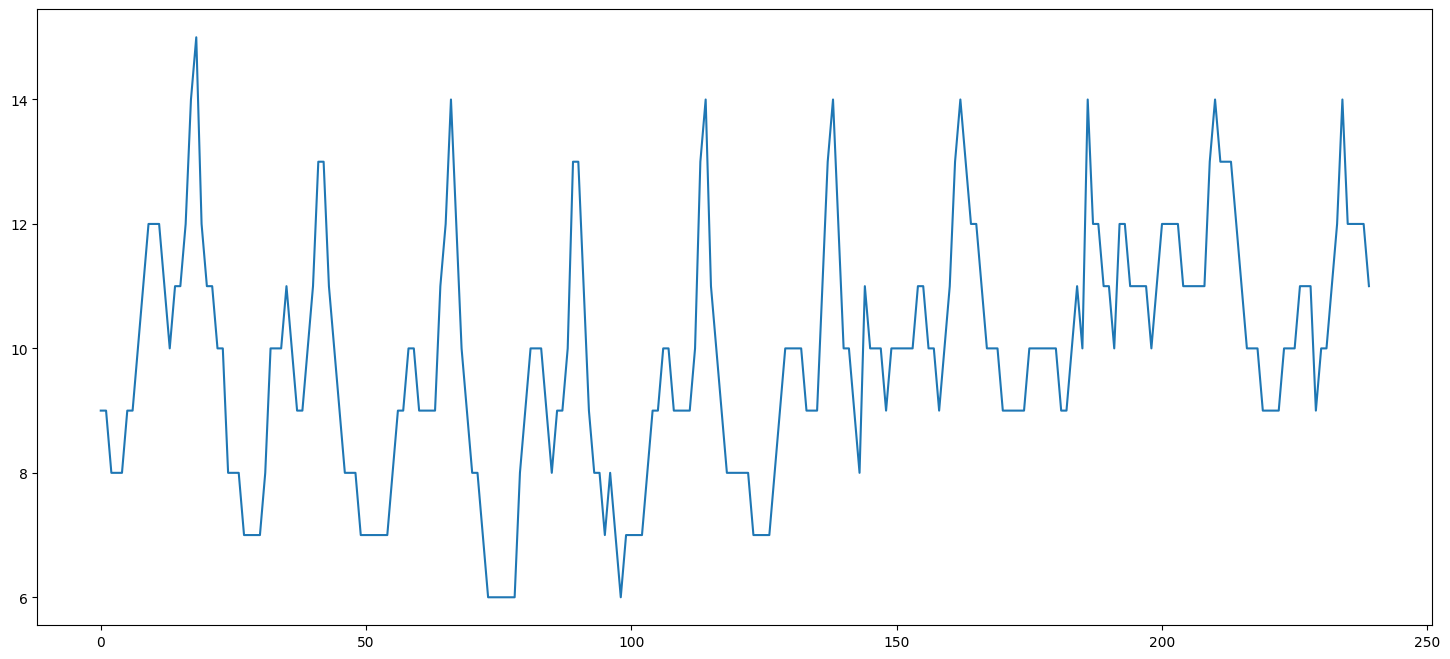

In [37]:
import matplotlib.pyplot as plot
# restaring the index
infoToUseFiltered.index = np.arange(1, len(infoToUseFiltered) + 1, 1)
print(infoToUseFiltered)
# reshape the data
dataToFit = []
for k in range(1, 11):
    print(k)
    data = infoToUseFiltered.loc[k,['dem1', 'dem2', 'dem3', 'dem4', 'dem5', 'dem6', 'dem7', 'dem8', 'dem9', 'dem10', 'dem11', 'dem12', 'dem13', 'dem14', 'dem15', 'dem16', 'dem17', 'dem18', 'dem19', 'dem20', 'dem21', 'dem22', 'dem23', 'dem24']]
    data = np.array(data)    
    dataToFit.append(data)
dataToFit = np.array(dataToFit)
dataToFit = dataToFit.flatten()
dataToFit = np.float64(dataToFit)
plot.plot(dataToFit)
np.sum(dataToFit)
np.mean(dataToFit)

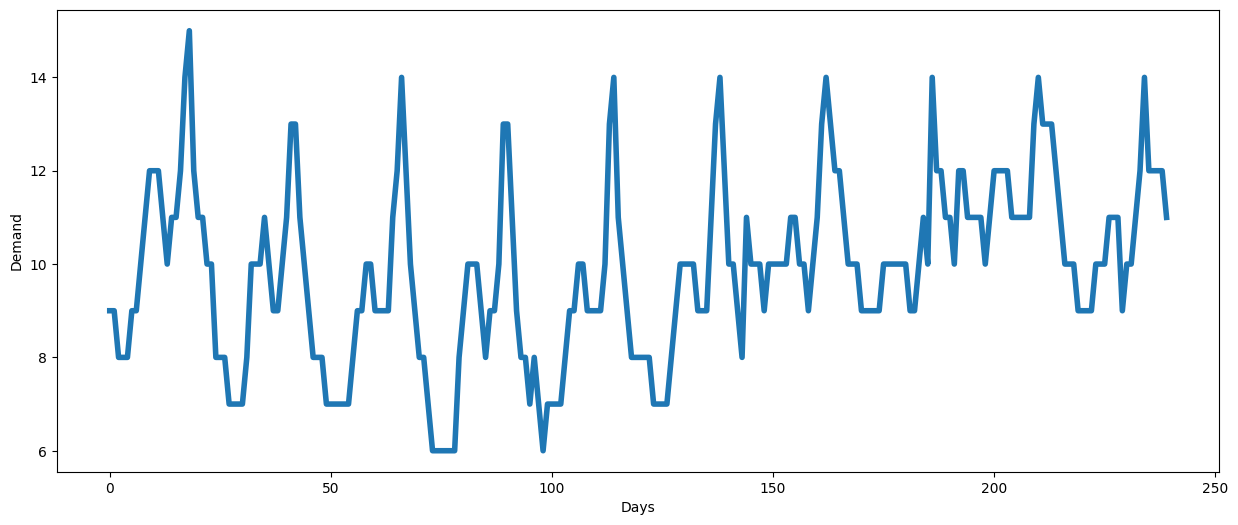

In [38]:
plt.figure(figsize = (15,6))
plt.plot(dataToFit,linewidth = 4)
plt.xlabel('Days')
plt.ylabel('Demand')
plt.show()

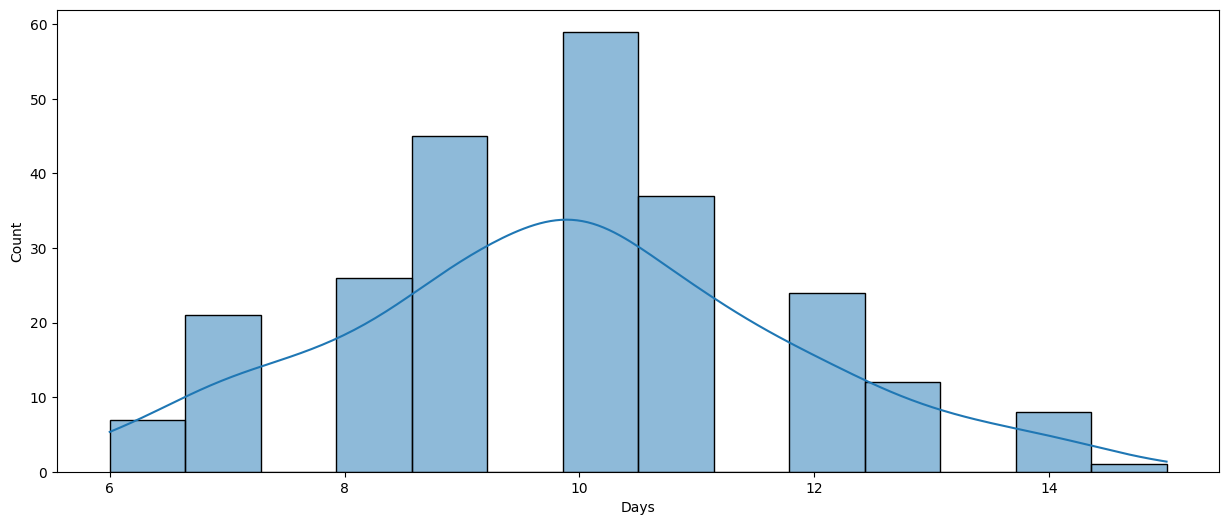

In [39]:
 #? Density Plot
plt.figure(figsize = (15,6))
sns.histplot(dataToFit, kde = True)
plt.xlabel('Days')
plt.ylabel('Count')
plt.show()